# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

## Load and normalize data

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import os
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset
from models import generator, discriminator
from sklearn.preprocessing import normalize

In [3]:
(benign_train, benign_test), (attack_train, attack_test) = get_flow_dataset(os.path.join('data', 'ids2017_sampled.csv'))

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
benign_train.shape

(1500, 41)

In [5]:
benign_test.shape

(3500, 41)

In [6]:
attack_train.shape

(1650, 41)

In [7]:
attack_test.shape

(3850, 41)

In [8]:
def max_norm(dataset):
    dataset = dataset - dataset.min(axis=0)
    dataset = normalize(dataset, axis=0, norm='max')
    return dataset

In [9]:
# normalize data
benign_train = max_norm(benign_train)
benign_test = max_norm(benign_test)
attack_train = max_norm(attack_train)
attack_test = max_norm(attack_test)

## Hyperparameters

In [10]:
# Size of input flow to discriminator
input_size = benign_train.shape[1]
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = [128, 64]
d_hidden_size = [128, 64]
# Leak factor for leaky ReLU
alpha = 0.01
# log interval
log_interval = 5

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [11]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated, g_hidden = generator(input_z, z_size, n_units=[z_size] + g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign, d_hidden_benign = discriminator(input_benign,
                                                                 n_units= [input_size] + d_hidden_size,
                                                                 alpha=alpha)
d_model_attack, d_logits_attack, d_hidden_attack = discriminator(g_model,
                                                                 reuse=True,
                                                                 n_units=[input_size] + d_hidden_size,
                                                                 alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all zeros, since these are all benign flows. In TensorFlow, it looks something like `labels = tf.zeros_like(tensor)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all ones. Remember that we want the discriminator to output 0 for benign flows and 1 for attack flows, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all zeros. The generator is trying to fool the discriminator, so it wants to discriminator to output zeros for attack flows.

In [12]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.zeros_like(d_logits_benign)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.ones_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.zeros_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [13]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [14]:
from copy import deepcopy
import time

batch_size = 100
epochs = 1000
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
# TODO: add outer-loop, which is test number, to see convergence trends
# TODO: modify training process - choose random 2 features and give 2 outputs randomly back
with tf.Session() as sess:
    total_start = time.time()
    sess.run(tf.global_variables_initializer())
    init_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    init_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})
    for e in range(epochs):
        start = time.time()
        np.random.shuffle(benign_train)
        np.random.shuffle(attack_train)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign_train.shape[0]//batch_size):
            batch_benign = benign_train[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack_train[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
#             if ii % log_interval == 0:
#                 original_flow = batch_attack
#                 generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
#                 attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
#                 original_flows[-1].append(deepcopy(original_flow[0]))
#                 generated_flows[-1].append(generated_flow[0])
#                 attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g),
              "Time elapsed: {:.4f}".format(time.time() - start)
             )    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')
    print('Total training time:', time.time() - total_start)
    
    final_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    final_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})

Epoch 1/1000... Discriminator Loss: 0.6014... Generator Loss: 2.3911 Time elapsed: 0.4851
Epoch 2/1000... Discriminator Loss: 0.1811... Generator Loss: 5.1047 Time elapsed: 0.1237
Epoch 3/1000... Discriminator Loss: 0.0566... Generator Loss: 7.3486 Time elapsed: 0.1269
Epoch 4/1000... Discriminator Loss: 0.0590... Generator Loss: 8.0094 Time elapsed: 0.1276
Epoch 5/1000... Discriminator Loss: 0.0450... Generator Loss: 7.9895 Time elapsed: 0.1198
Epoch 6/1000... Discriminator Loss: 0.1156... Generator Loss: 8.9321 Time elapsed: 0.1207
Epoch 7/1000... Discriminator Loss: 0.0259... Generator Loss: 8.5045 Time elapsed: 0.1235
Epoch 8/1000... Discriminator Loss: 0.1095... Generator Loss: 8.7703 Time elapsed: 0.1236
Epoch 9/1000... Discriminator Loss: 0.1215... Generator Loss: 7.8182 Time elapsed: 0.1222
Epoch 10/1000... Discriminator Loss: 0.0447... Generator Loss: 8.9815 Time elapsed: 0.1190
Epoch 11/1000... Discriminator Loss: 0.0867... Generator Loss: 8.6839 Time elapsed: 0.1156
Epoch 12

Epoch 91/1000... Discriminator Loss: 0.0413... Generator Loss: 16.5397 Time elapsed: 0.1276
Epoch 92/1000... Discriminator Loss: 0.0130... Generator Loss: 15.2063 Time elapsed: 0.1218
Epoch 93/1000... Discriminator Loss: 0.0059... Generator Loss: 16.1759 Time elapsed: 0.1268
Epoch 94/1000... Discriminator Loss: 0.0060... Generator Loss: 16.0874 Time elapsed: 0.1185
Epoch 95/1000... Discriminator Loss: 0.0018... Generator Loss: 17.6190 Time elapsed: 0.1154
Epoch 96/1000... Discriminator Loss: 0.0014... Generator Loss: 16.5206 Time elapsed: 0.1177
Epoch 97/1000... Discriminator Loss: 0.0036... Generator Loss: 16.8154 Time elapsed: 0.1235
Epoch 98/1000... Discriminator Loss: 0.0016... Generator Loss: 16.9040 Time elapsed: 0.1198
Epoch 99/1000... Discriminator Loss: 0.0001... Generator Loss: 18.2624 Time elapsed: 0.1195
Epoch 100/1000... Discriminator Loss: 0.0019... Generator Loss: 17.0485 Time elapsed: 0.1185
Epoch 101/1000... Discriminator Loss: 0.0027... Generator Loss: 17.7186 Time el

Epoch 180/1000... Discriminator Loss: 0.0008... Generator Loss: 33.7947 Time elapsed: 0.1283
Epoch 181/1000... Discriminator Loss: 0.0001... Generator Loss: 33.0568 Time elapsed: 0.1231
Epoch 182/1000... Discriminator Loss: 0.0007... Generator Loss: 30.6162 Time elapsed: 0.1235
Epoch 183/1000... Discriminator Loss: 0.0005... Generator Loss: 34.9605 Time elapsed: 0.1208
Epoch 184/1000... Discriminator Loss: 0.0003... Generator Loss: 33.4036 Time elapsed: 0.1217
Epoch 185/1000... Discriminator Loss: 0.0001... Generator Loss: 33.1318 Time elapsed: 0.1149
Epoch 186/1000... Discriminator Loss: 0.0004... Generator Loss: 32.3706 Time elapsed: 0.1150
Epoch 187/1000... Discriminator Loss: 0.0015... Generator Loss: 33.2326 Time elapsed: 0.1193
Epoch 188/1000... Discriminator Loss: 0.0070... Generator Loss: 33.2102 Time elapsed: 0.1235
Epoch 189/1000... Discriminator Loss: 0.0069... Generator Loss: 32.7010 Time elapsed: 0.1115
Epoch 190/1000... Discriminator Loss: 0.0016... Generator Loss: 31.209

Epoch 269/1000... Discriminator Loss: 0.0000... Generator Loss: 37.3806 Time elapsed: 0.1221
Epoch 270/1000... Discriminator Loss: 0.0002... Generator Loss: 38.0728 Time elapsed: 0.1247
Epoch 271/1000... Discriminator Loss: 0.0005... Generator Loss: 36.9216 Time elapsed: 0.1266
Epoch 272/1000... Discriminator Loss: 0.0000... Generator Loss: 38.8172 Time elapsed: 0.1249
Epoch 273/1000... Discriminator Loss: 0.0001... Generator Loss: 40.7854 Time elapsed: 0.1198
Epoch 274/1000... Discriminator Loss: 0.0004... Generator Loss: 38.1093 Time elapsed: 0.1121
Epoch 275/1000... Discriminator Loss: 0.0001... Generator Loss: 38.4594 Time elapsed: 0.1192
Epoch 276/1000... Discriminator Loss: 0.0003... Generator Loss: 40.9985 Time elapsed: 0.1176
Epoch 277/1000... Discriminator Loss: 0.0003... Generator Loss: 37.9699 Time elapsed: 0.1209
Epoch 278/1000... Discriminator Loss: 0.0001... Generator Loss: 39.3015 Time elapsed: 0.1148
Epoch 279/1000... Discriminator Loss: 0.0001... Generator Loss: 39.040

Epoch 358/1000... Discriminator Loss: 0.0001... Generator Loss: 41.7319 Time elapsed: 0.1176
Epoch 359/1000... Discriminator Loss: 0.0000... Generator Loss: 44.0215 Time elapsed: 0.1141
Epoch 360/1000... Discriminator Loss: 0.0001... Generator Loss: 44.3702 Time elapsed: 0.1094
Epoch 361/1000... Discriminator Loss: 0.0000... Generator Loss: 43.7561 Time elapsed: 0.1116
Epoch 362/1000... Discriminator Loss: 0.0001... Generator Loss: 43.6796 Time elapsed: 0.1146
Epoch 363/1000... Discriminator Loss: 0.0001... Generator Loss: 43.4980 Time elapsed: 0.1144
Epoch 364/1000... Discriminator Loss: 0.0001... Generator Loss: 42.9360 Time elapsed: 0.1214
Epoch 365/1000... Discriminator Loss: 0.0000... Generator Loss: 45.4622 Time elapsed: 0.1258
Epoch 366/1000... Discriminator Loss: 0.0000... Generator Loss: 43.7290 Time elapsed: 0.1122
Epoch 367/1000... Discriminator Loss: 0.0000... Generator Loss: 44.3002 Time elapsed: 0.1152
Epoch 368/1000... Discriminator Loss: 0.0000... Generator Loss: 45.158

Epoch 447/1000... Discriminator Loss: 0.0000... Generator Loss: 47.6178 Time elapsed: 0.1195
Epoch 448/1000... Discriminator Loss: 0.0000... Generator Loss: 47.1128 Time elapsed: 0.1182
Epoch 449/1000... Discriminator Loss: 0.0000... Generator Loss: 47.5769 Time elapsed: 0.1094
Epoch 450/1000... Discriminator Loss: 0.0001... Generator Loss: 44.8568 Time elapsed: 0.1184
Epoch 451/1000... Discriminator Loss: 0.0000... Generator Loss: 48.5868 Time elapsed: 0.1131
Epoch 452/1000... Discriminator Loss: 0.0001... Generator Loss: 49.6553 Time elapsed: 0.1161
Epoch 453/1000... Discriminator Loss: 0.0000... Generator Loss: 47.7974 Time elapsed: 0.1181
Epoch 454/1000... Discriminator Loss: 0.0000... Generator Loss: 48.5529 Time elapsed: 0.1106
Epoch 455/1000... Discriminator Loss: 0.0000... Generator Loss: 46.5688 Time elapsed: 0.1142
Epoch 456/1000... Discriminator Loss: 0.0000... Generator Loss: 47.2677 Time elapsed: 0.1224
Epoch 457/1000... Discriminator Loss: 0.0000... Generator Loss: 45.693

Epoch 536/1000... Discriminator Loss: 0.0000... Generator Loss: 50.7326 Time elapsed: 0.1200
Epoch 537/1000... Discriminator Loss: 0.0000... Generator Loss: 50.3417 Time elapsed: 0.1227
Epoch 538/1000... Discriminator Loss: 0.0000... Generator Loss: 48.7032 Time elapsed: 0.1199
Epoch 539/1000... Discriminator Loss: 0.0000... Generator Loss: 51.0924 Time elapsed: 0.1267
Epoch 540/1000... Discriminator Loss: 0.0000... Generator Loss: 47.5280 Time elapsed: 0.1110
Epoch 541/1000... Discriminator Loss: 0.0000... Generator Loss: 50.6291 Time elapsed: 0.1109
Epoch 542/1000... Discriminator Loss: 0.0000... Generator Loss: 52.7185 Time elapsed: 0.1152
Epoch 543/1000... Discriminator Loss: 0.0000... Generator Loss: 49.6107 Time elapsed: 0.1157
Epoch 544/1000... Discriminator Loss: 0.0000... Generator Loss: 50.1803 Time elapsed: 0.1115
Epoch 545/1000... Discriminator Loss: 0.0000... Generator Loss: 50.9654 Time elapsed: 0.1161
Epoch 546/1000... Discriminator Loss: 0.0000... Generator Loss: 48.165

Epoch 625/1000... Discriminator Loss: 0.0000... Generator Loss: 53.4153 Time elapsed: 0.1143
Epoch 626/1000... Discriminator Loss: 0.0000... Generator Loss: 51.2781 Time elapsed: 0.1116
Epoch 627/1000... Discriminator Loss: 0.0000... Generator Loss: 54.6348 Time elapsed: 0.1074
Epoch 628/1000... Discriminator Loss: 0.0000... Generator Loss: 52.9012 Time elapsed: 0.1123
Epoch 629/1000... Discriminator Loss: 0.0000... Generator Loss: 55.0277 Time elapsed: 0.1204
Epoch 630/1000... Discriminator Loss: 0.0000... Generator Loss: 54.0147 Time elapsed: 0.1106
Epoch 631/1000... Discriminator Loss: 0.0000... Generator Loss: 50.9479 Time elapsed: 0.1096
Epoch 632/1000... Discriminator Loss: 0.0000... Generator Loss: 54.7214 Time elapsed: 0.1152
Epoch 633/1000... Discriminator Loss: 0.0000... Generator Loss: 52.1510 Time elapsed: 0.1204
Epoch 634/1000... Discriminator Loss: 0.0000... Generator Loss: 54.8446 Time elapsed: 0.1209
Epoch 635/1000... Discriminator Loss: 0.0000... Generator Loss: 52.839

Epoch 714/1000... Discriminator Loss: 0.0000... Generator Loss: 52.2624 Time elapsed: 0.1187
Epoch 715/1000... Discriminator Loss: 0.0000... Generator Loss: 56.6767 Time elapsed: 0.1066
Epoch 716/1000... Discriminator Loss: 0.0000... Generator Loss: 55.2305 Time elapsed: 0.1113
Epoch 717/1000... Discriminator Loss: 0.0000... Generator Loss: 55.2520 Time elapsed: 0.1134
Epoch 718/1000... Discriminator Loss: 0.0000... Generator Loss: 55.0800 Time elapsed: 0.1070
Epoch 719/1000... Discriminator Loss: 0.0000... Generator Loss: 52.5881 Time elapsed: 0.1155
Epoch 720/1000... Discriminator Loss: 0.0000... Generator Loss: 57.3383 Time elapsed: 0.1083
Epoch 721/1000... Discriminator Loss: 0.0000... Generator Loss: 55.6257 Time elapsed: 0.1183
Epoch 722/1000... Discriminator Loss: 0.0000... Generator Loss: 54.9323 Time elapsed: 0.1091
Epoch 723/1000... Discriminator Loss: 0.0000... Generator Loss: 54.1678 Time elapsed: 0.1085
Epoch 724/1000... Discriminator Loss: 0.0000... Generator Loss: 55.804

Epoch 804/1000... Discriminator Loss: 0.0000... Generator Loss: 57.7630 Time elapsed: 0.1084
Epoch 805/1000... Discriminator Loss: 0.0000... Generator Loss: 59.1560 Time elapsed: 0.1111
Epoch 806/1000... Discriminator Loss: 0.0000... Generator Loss: 56.5535 Time elapsed: 0.1192
Epoch 807/1000... Discriminator Loss: 0.0000... Generator Loss: 61.1737 Time elapsed: 0.1099
Epoch 808/1000... Discriminator Loss: 0.0000... Generator Loss: 59.0334 Time elapsed: 0.1140
Epoch 809/1000... Discriminator Loss: 0.0000... Generator Loss: 57.4093 Time elapsed: 0.1173
Epoch 810/1000... Discriminator Loss: 0.0000... Generator Loss: 60.5912 Time elapsed: 0.1113
Epoch 811/1000... Discriminator Loss: 0.0000... Generator Loss: 59.1096 Time elapsed: 0.1131
Epoch 812/1000... Discriminator Loss: 0.0000... Generator Loss: 60.2583 Time elapsed: 0.1111
Epoch 813/1000... Discriminator Loss: 0.0000... Generator Loss: 59.3568 Time elapsed: 0.1155
Epoch 814/1000... Discriminator Loss: 0.0000... Generator Loss: 59.200

Epoch 894/1000... Discriminator Loss: 0.0000... Generator Loss: 60.3839 Time elapsed: 0.1106
Epoch 895/1000... Discriminator Loss: 0.0000... Generator Loss: 58.7785 Time elapsed: 0.1166
Epoch 896/1000... Discriminator Loss: 0.0000... Generator Loss: 62.0318 Time elapsed: 0.1148
Epoch 897/1000... Discriminator Loss: 0.0000... Generator Loss: 58.5005 Time elapsed: 0.1150
Epoch 898/1000... Discriminator Loss: 0.0000... Generator Loss: 59.4346 Time elapsed: 0.1154
Epoch 899/1000... Discriminator Loss: 0.0000... Generator Loss: 59.9803 Time elapsed: 0.1148
Epoch 900/1000... Discriminator Loss: 0.0000... Generator Loss: 59.3894 Time elapsed: 0.1124
Epoch 901/1000... Discriminator Loss: 0.0000... Generator Loss: 60.1856 Time elapsed: 0.1159
Epoch 902/1000... Discriminator Loss: 0.0000... Generator Loss: 60.2296 Time elapsed: 0.1179
Epoch 903/1000... Discriminator Loss: 0.0000... Generator Loss: 62.5182 Time elapsed: 0.1107
Epoch 904/1000... Discriminator Loss: 0.0000... Generator Loss: 61.960

Epoch 983/1000... Discriminator Loss: 0.0000... Generator Loss: 64.3535 Time elapsed: 0.1186
Epoch 984/1000... Discriminator Loss: 0.0000... Generator Loss: 64.3069 Time elapsed: 0.1170
Epoch 985/1000... Discriminator Loss: 0.0000... Generator Loss: 64.8379 Time elapsed: 0.1109
Epoch 986/1000... Discriminator Loss: 0.0000... Generator Loss: 60.2930 Time elapsed: 0.1169
Epoch 987/1000... Discriminator Loss: 0.0000... Generator Loss: 61.4820 Time elapsed: 0.1078
Epoch 988/1000... Discriminator Loss: 0.0000... Generator Loss: 60.4306 Time elapsed: 0.1076
Epoch 989/1000... Discriminator Loss: 0.0000... Generator Loss: 59.6012 Time elapsed: 0.1094
Epoch 990/1000... Discriminator Loss: 0.0000... Generator Loss: 57.5165 Time elapsed: 0.1174
Epoch 991/1000... Discriminator Loss: 0.0000... Generator Loss: 64.9980 Time elapsed: 0.1228
Epoch 992/1000... Discriminator Loss: 0.0000... Generator Loss: 58.9017 Time elapsed: 0.1147
Epoch 993/1000... Discriminator Loss: 0.0000... Generator Loss: 62.889

## Training loss

Here we'll check out the training losses for the generator and discriminator.

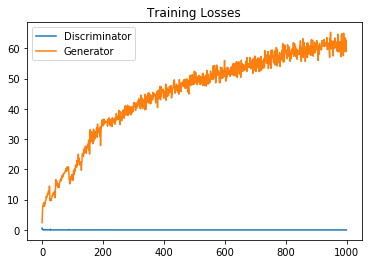

In [15]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Test Part

In [16]:
# TODO: test if discriminator is fooled

In [17]:
print('Accuracy before training')
print('Discriminator benign test accuracy:', (init_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (init_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((init_benign_test_score <= 0.5).sum() + (init_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy before training
Discriminator benign test accuracy: 0.7728571428571429
Discriminator attack test accuracy: 0.7324675324675325
Discriminator total test accuracy: 0.7517006802721088


In [18]:
print('Accuracy after training')
print('Discriminator benign test accuracy:', (final_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (final_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((final_benign_test_score <= 0.5).sum() + (final_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy after training
Discriminator benign test accuracy: 0.9737142857142858
Discriminator attack test accuracy: 0.9994805194805195
Discriminator total test accuracy: 0.9872108843537415


# Output Visualization

In [19]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)
fig_size = split_to_two_nearest_factor(input_size)
import numpy as np
import matplotlib.pyplot as plt

# fooled = 0

# fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
# columns = 2
# rows = len(original_flows)
# for i in range(rows):
#     original_img = original_flows[i][0]
#     generated_img = generated_flows[i][0]
#     ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
#     ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
#     plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
#     plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     if attack_scores[i][0] <= 0.5:
#         ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
#         fooled += 1
#     else:
#         ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
# plt.show()
# print('Fooled rate:', fooled / len(original_flows))

IndexError: list index out of range

# Generate attack flows

In [ ]:
#TODO: generate attack flows for Kaihua's discrimination